In [1]:
# Import main libraries necessary for this project
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

# Import libraries needed for reading image and processing it
import csv
from PIL import Image
from scipy.ndimage import rotate

# Pretty display for notebooks
%matplotlib inline

In [2]:
# Training letters images and labels files
letters_training_images_file_path = "csvTrainImages 13440x1024.csv"
letters_training_labels_file_path = "csvTrainLabel 13440x1.csv"
# Testing letters images and labels files
letters_testing_images_file_path = "csvTestImages 3360x1024.csv"
letters_testing_labels_file_path = "csvTestLabel 3360x1.csv"

# Loading dataset into dataframes
training_letters_images = pd.read_csv(letters_training_images_file_path, header=None)
training_letters_labels = pd.read_csv(letters_training_labels_file_path, header=None)
testing_letters_images = pd.read_csv(letters_testing_images_file_path, header=None)
testing_letters_labels = pd.read_csv(letters_testing_labels_file_path, header=None)

# print statistics about the dataset
print("There are %d training arabic letter images of 32x32 pixels." %training_letters_images.shape[0])
print("There are %d testing arabic letter images of 32x32 pixels." %testing_letters_images.shape[0])
training_letters_images.head()

There are 13440 training arabic letter images of 32x32 pixels.
There are 3360 testing arabic letter images of 32x32 pixels.


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def convert_values_to_image(image_values, display=False):
    image_array = np.asarray(image_values)
    image_array = image_array.reshape(32,32).astype('uint8')
    # The original dataset is reflected so we will flip it then rotate for a better view only.
    image_array = np.flip(image_array, 0)
    image_array = rotate(image_array, -90)
    new_image = Image.fromarray(image_array)
    if display == True:
        new_image.show()
    return new_image

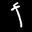

In [ ]:
convert_values_to_image(training_letters_images.loc[0], True)


**Data Pre-processing**

In [ ]:
#Normalization 

training_letters_images_scaled = training_letters_images.values.astype('float32')/255
training_letters_labels = training_letters_labels.values.astype('int32')

testing_letters_images_scaled = testing_letters_images.values.astype('float32')/255
testing_letters_labels = testing_letters_labels.values.astype('int32')


In [ ]:
testing_letters_labels

array([[ 1],
       [ 1],
       [ 2],
       ...,
       [27],
       [28],
       [28]], dtype=int32)

In [ ]:
#categorical encoding 
#'Alef' --> '0 etc,

from tensorflow.keras.utils import to_categorical

# one hot encoding
# number of classes = 28 (arabic alphabet classes)
number_of_classes = 28

training_letters_labels_encoded = to_categorical(training_letters_labels-1, num_classes=number_of_classes)
testing_letters_labels_encoded = to_categorical(testing_letters_labels-1, num_classes=number_of_classes)
print(training_letters_labels_encoded)


[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
"""
 input shape should be (nb_samples,rows,columns,channels)
"""
# reshape input letter images to 32x32x1
training_letters_images_scaled = training_letters_images_scaled.reshape([-1, 32, 32, 1])
testing_letters_images_scaled = testing_letters_images_scaled.reshape([-1, 32, 32, 1])

print(training_letters_images_scaled.shape, training_letters_labels_encoded.shape, testing_letters_images_scaled.shape, testing_letters_labels_encoded.shape)


(13440, 32, 32, 1) (13440, 28) (3360, 32, 32, 1) (3360, 28)


**building The Model**

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense

def create_model(optimizer='adam', kernel_initializer='he_normal', activation='relu'):
    # create model
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, padding='same', input_shape=(32, 32, 1), kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=3, padding='same', kernel_initializer=kernel_initializer, activation=activation))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())

    #Fully connected final layer
    model.add(Dense(28, activation='softmax'))

    # Compile model
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    return model

In [ ]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 32)       1

In [ ]:
# import pydot
# from tensorflow.keras.utils import plot_model

# plot_model(model, to_file="model.png", show_shapes=True)
# from IPython.display import Image as IPythonImage
# display(IPythonImage('model.png'))

In [ ]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# define the grid search parameters
optimizer = ['RMSprop', 'Adam', 'Adagrad', 'Nadam']
kernel_initializer = ['normal', 'uniform']
activation = ['relu', 'linear', 'tanh']

param_grid = dict(optimizer=optimizer, kernel_initializer=kernel_initializer, activation=activation)


In [ ]:
print(training_letters_images_scaled.shape)
print(training_letters_labels_encoded.shape)

(13440, 32, 32, 1)
(13440, 28)


In [ ]:
# epochs = 5
# batch_size = 20 # 20 divides the training data samples

# #creating the models with different hyperparameters
# for a,b,c in [(x,y,z) for x in optimizer for z in activation for y in kernel_initializer]:
#     params = {'optimizer' : a , 'kernel_initializer' : b , 'activation' : c}
#     print(params)
#     curr_model = create_model(a, b, c)
#     curr_model.fit(training_letters_images_scaled, training_letters_labels_encoded, 
#                     validation_data=(testing_letters_images_scaled, testing_letters_labels_encoded),
#                     epochs=epochs, batch_size=batch_size, verbose=1)
#     print("=============================================================================")

{'optimizer': 'RMSprop', 'kernel_initializer': 'normal', 'activation': 'relu'}
Epoch 1/5
672/672 [==============================] - 9s 9ms/step - loss: 1.4273 - accuracy: 0.5528 - val_loss: 1.7163 - val_accuracy: 0.4113
Epoch 2/5
672/672 [==============================] - 6s 9ms/step - loss: 0.5308 - accuracy: 0.8211 - val_loss: 0.6634 - val_accuracy: 0.7821
Epoch 3/5
672/672 [==============================] - 6s 9ms/step - loss: 0.3944 - accuracy: 0.8689 - val_loss: 0.3706 - val_accuracy: 0.8667
Epoch 4/5
672/672 [==============================] - 6s 9ms/step - loss: 0.3336 - accuracy: 0.8906 - val_loss: 0.2453 - val_accuracy: 0.9226
Epoch 5/5
672/672 [==============================] - 6s 9ms/step - loss: 0.2936 - accuracy: 0.9010 - val_loss: 0.3022 - val_accuracy: 0.8994
{'optimizer': 'RMSprop', 'kernel_initializer': 'uniform', 'activation': 'relu'}
Epoch 1/5
672/672 [==============================] - 8s 9ms/step - loss: 1.2369 - accuracy: 0.6127 - val_loss: 0.6862 - val_accuracy: 0.

From the above results we can see that best parameters are:

Optimizer: Adam

Kernel_initializer: uniform

Activation: relu

In [ ]:
model = create_model(optimizer='Adam', kernel_initializer='uniform', activation='relu')


**Model Training**

In [ ]:
from keras.callbacks import ModelCheckpoint  

# using checkpoints to save model weights to be used later instead of training again on the same epochs.
checkpointer = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
history = model.fit(training_letters_images_scaled, training_letters_labels_encoded, 
                    validation_data=(testing_letters_images_scaled, testing_letters_labels_encoded),
                    epochs=40, batch_size=30, verbose=1, callbacks=[checkpointer])

Epoch 1/40
443/448 [============================>.] - ETA: 0s - loss: 1.4029 - accuracy: 0.5727
Epoch 1: val_loss improved from inf to 6.53169, saving model to weights.hdf5
448/448 [==============================] - 5s 9ms/step - loss: 1.3942 - accuracy: 0.5751 - val_loss: 6.5317 - val_accuracy: 0.0384
Epoch 2/40
443/448 [============================>.] - ETA: 0s - loss: 0.5251 - accuracy: 0.8318
Epoch 2: val_loss improved from 6.53169 to 1.04839, saving model to weights.hdf5
448/448 [==============================] - 4s 8ms/step - loss: 0.5234 - accuracy: 0.8321 - val_loss: 1.0484 - val_accuracy: 0.6595
Epoch 3/40
445/448 [============================>.] - ETA: 0s - loss: 0.3917 - accuracy: 0.8755
Epoch 3: val_loss improved from 1.04839 to 0.42086, saving model to weights.hdf5
448/448 [==============================] - 4s 8ms/step - loss: 0.3912 - accuracy: 0.8757 - val_loss: 0.4209 - val_accuracy: 0.8753
Epoch 4/40
445/448 [============================>.] - ETA: 0s - loss: 0.3219 - a

In [ ]:
#Load the Model with the Best Validation Loss

model.load_weights('weights.hdf5')


**Test model**

In [ ]:
# Final evaluation of the model
metrics = model.evaluate(testing_letters_images_scaled, testing_letters_labels_encoded, verbose=1)
print("Test Accuracy: {}".format(metrics[1]))
print("Test Loss: {}".format(metrics[0]))

105/105 [==============================] - 1s 4ms/step - loss: 0.1167 - accuracy: 0.9688
Test Accuracy: 0.96875
Test Loss: 0.11672487109899521


In [ ]:
from sklearn.metrics import classification_report


def get_predicted_classes(model, data, labels=None):
    image_predictions = model.predict(data)
    predicted_classes = np.argmax(image_predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    return predicted_classes, true_classes, image_predictions


def get_classification_report(y_true, y_pred):
    print(classification_report(y_true, y_pred))

In [ ]:
y_pred, y_true, image_predictions = get_predicted_classes(model, testing_letters_images_scaled, testing_letters_labels_encoded)
get_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       120
           1       1.00      0.99      1.00       120
           2       0.91      0.95      0.93       120
           3       0.93      0.96      0.94       120
           4       0.98      0.98      0.98       120
           5       0.97      0.96      0.97       120
           6       0.99      0.98      0.99       120
           7       0.97      0.93      0.95       120
           8       0.93      0.96      0.94       120
           9       0.92      1.00      0.96       120
          10       0.99      0.90      0.94       120
          11       0.98      1.00      0.99       120
          12       0.98      1.00      0.99       120
          13       0.95      0.98      0.97       120
          14       0.98      0.95      0.97       120
          15       0.95      0.97      0.96       120
          16       0.98      0.95      0.97       120
          17       0.97    

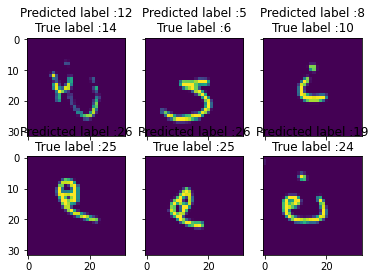

In [ ]:
import matplotlib.pyplot as plt

errors = (y_pred - y_true != 0)


Y_pred_classes_errors = y_pred[errors]
Y_pred_errors = image_predictions[errors]
Y_true_errors = y_true[errors]
X_val_errors = testing_letters_images_scaled[errors]


def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            image_array = np.flip(img_errors[error], 0)
            image_array = rotate(img_errors[error], -90)
            ax[row,col].imshow((image_array).reshape((32,32)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted letters
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)